In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import scIB
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
default_fig_size = (8,8)
plt.rcParams['figure.figsize'] = default_fig_size

In [3]:
adata_file = "/storage/groups/ml01/workspace/group.daniela/MCA_normalised/Mammary.h5ad"
adata_file = "/storage/groups/ml01/workspace/group.daniela/tm/facs/norm/Thymus_raw.h5ad"
adata = sc.read(adata_file, cache=True)

In [4]:
adata

AnnData object with n_obs × n_vars = 1349 × 23433 
    obs: 'tissue', 'sample', 'sex', 'cell_type', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'size_factors'
    layers: 'counts'

In [5]:
scIB.preprocessing.reduce_data(adata, hvg=True, batch_key='tissue', pca=True, umap=True)

HVG
Computed 2000 highly variable genes
PCA
Nearest Neigbours
UMAP


In [8]:
opt_clus = scIB.clustering.opt_louvain(adata, label='cell_type', plot=True)
opt_clus[0:2]

(0.1, 0.22202821205467524)

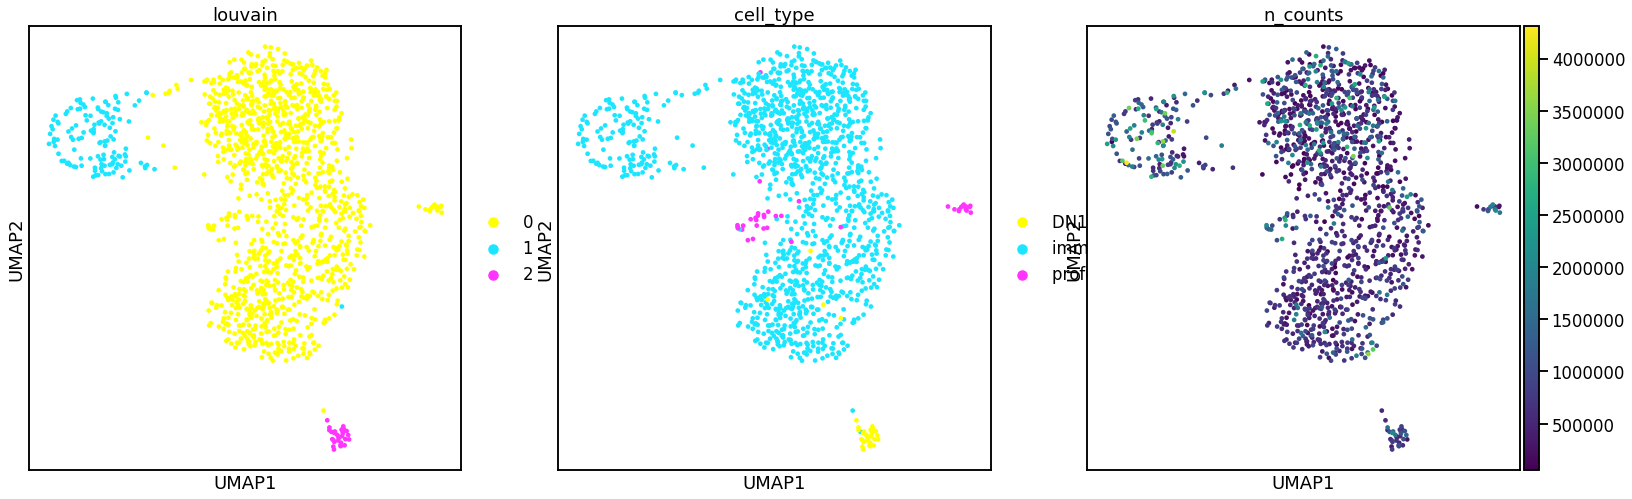

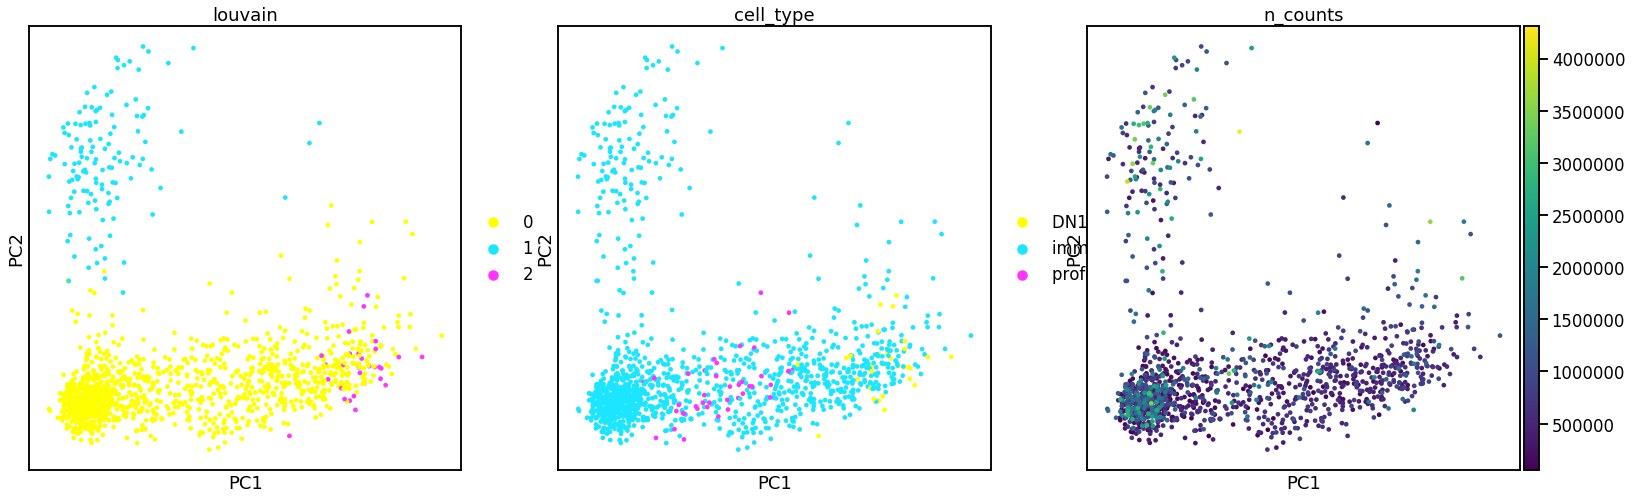

In [9]:
sc.pl.umap(adata, color=['louvain', 'cell_type', 'n_counts'], palette=sc.pl.palettes.godsnot_64)
sc.pl.pca(adata, color=['louvain', 'cell_type', 'n_counts'], palette=sc.pl.palettes.godsnot_64)

## Integrated Data

In [8]:
integrated = pickle.load(open(data_dir+'processed/integrated_dict.h5ad', "rb"))

NameError: name 'data_dir' is not defined

## Silhouette score

In [8]:
sil = scIB.metrics.silhouette_score(adata, batch_key='sample', group_key='cell_type', verbose=False)

In [9]:
sil.head()

,group,silhouette_score
0,DN1 thymic pro-T cell,0.089117
1,DN1 thymic pro-T cell,0.054605
2,DN1 thymic pro-T cell,0.119795
3,DN1 thymic pro-T cell,0.000000
4,DN1 thymic pro-T cell,0.199306


mean silhouette per cell:        silhouette_score
group                  
0              0.033530
1              0.082013
2              0.041107
3              0.133055
4              0.103523


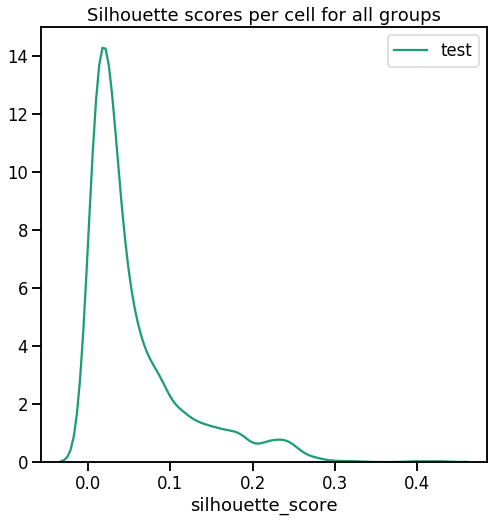


mean silhouette per cell:        silhouette_score
group                  
0              0.033530
1              0.082013
2              0.041107
3              0.133055
4              0.103523


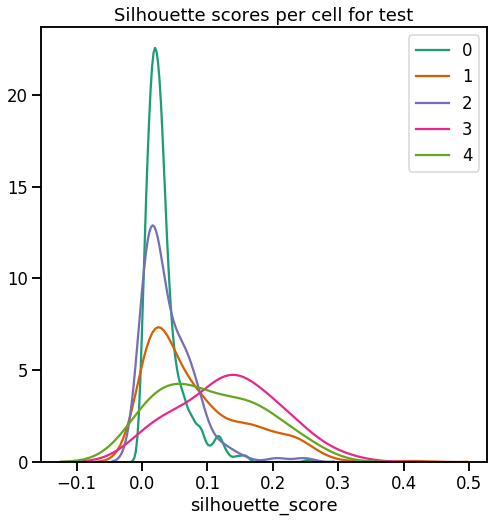

In [8]:
scIB.metrics.plot_silhouette_score({'test' : adata}, 
                                   batch_key='sample', group_key='louvain',
                                   per_group=True)

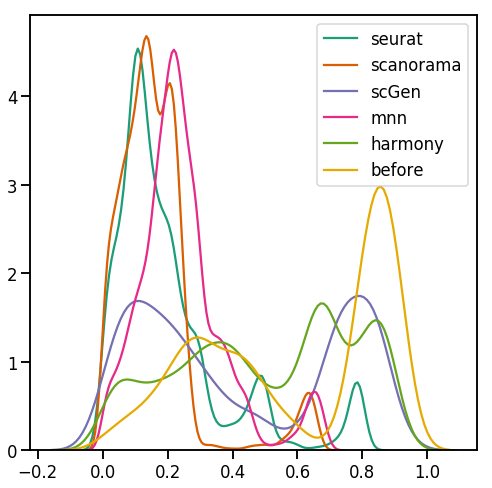

In [4]:
scIB.metrics.plot_silhouette_score(integrated, verbose=False)

## Simple Cluster overlap

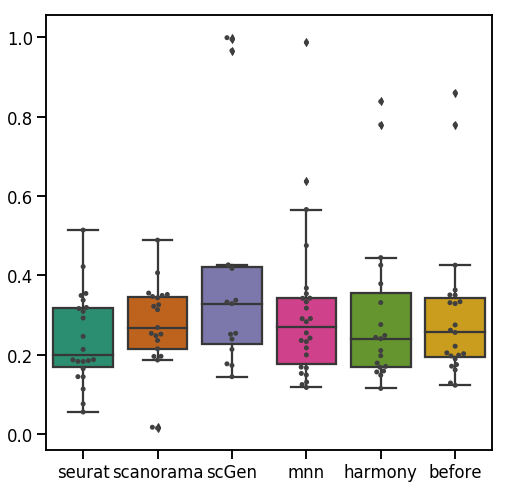

In [5]:
scIB.metrics.plot_cluster_overlap(integrated, group1='louvain', group2='louvain_post', df=False)

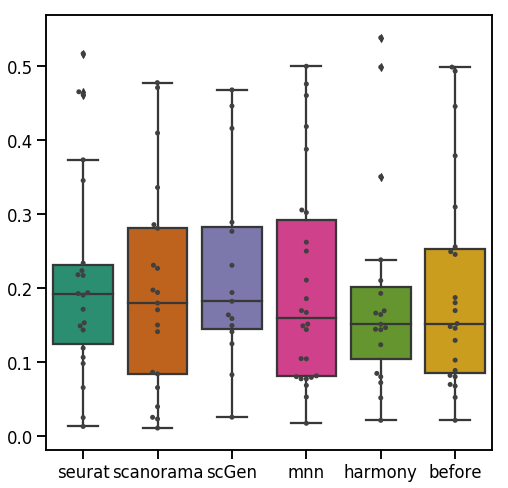

In [6]:
scIB.metrics.plot_cluster_overlap(integrated, group1='cell_ontology_class', group2='louvain_post', df=False)

## NMI Normalized mutual information

### Time comparison

Scikit-learn with `average_method='max'`

In [9]:
%timeit for x in range(100): scIB.metrics.nmi(adata, group1='cell_type', group2='louvain')

8.88 s ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
scIB.metrics.nmi(adata, group1='cell_type', group2='louvain')

0.4693874266278376

Lancichinetti 2009

In [10]:
%timeit for x in range(100): scIB.metrics.nmi(adata, group1='cell_type', group2='louvain', method='Lancichinetti', nmi_dir='../../../mutual3/')

29.7 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
scIB.metrics.nmi(adata, group1='cell_type', group2='louvain', method='Lancichinetti', nmi_dir='../../../mutual3/')

0.096854

Overlap NMI 2011

In [11]:
%timeit for x in range(100): scIB.metrics.nmi(adata, group1='cell_type', group2='louvain', method='ONMI', nmi_dir='../../../Overlapping-NMI/')

../../../Overlapping-NMI/onmi: error while loading shared libraries: libgsl.so.23: cannot open shared object file: No such file or directory



IndexError: list index out of range

## ARI Adjusted rand index

In [12]:
scIB.metrics.ari(adata, group1='cell_type', group2='louvain')

0.3749636053615194

## PC Regression

In [6]:
scIB.metrics.pc_regression(
    adata.obsm['X_pca'], 
    adata.obs['n_counts'], 
    pca_sd=adata.uns['pca']['variance']
)

PC regression


0.039589964898912845

In [7]:
scIB.metrics.pc_regression(adata.X, adata.obs['n_counts'])

PCA
PC regression


0.04983906561952651

In [8]:
scIB.metrics.pc_regression(adata.X, adata.obs['cell_type'])

PCA
PC regression


0.013505357257220978

In [10]:
scIB.me.pcr(adata, covariate='sample')

covariate: sample
PC regression


0.08857045391798798